# DEMETER2 in Stan

In [56]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

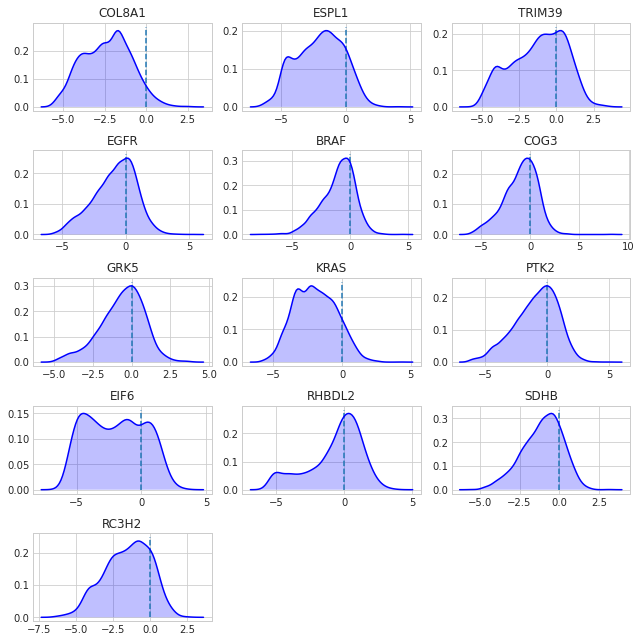

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

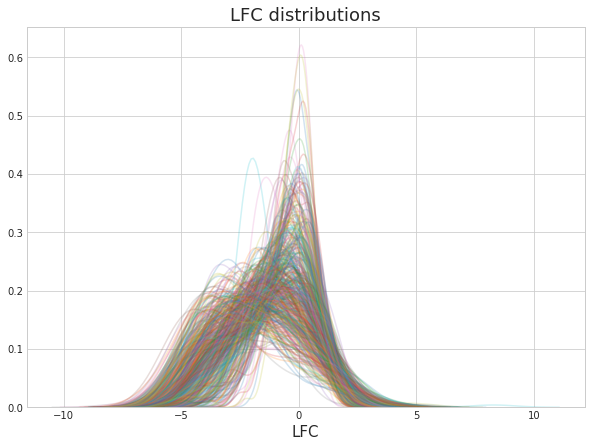

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

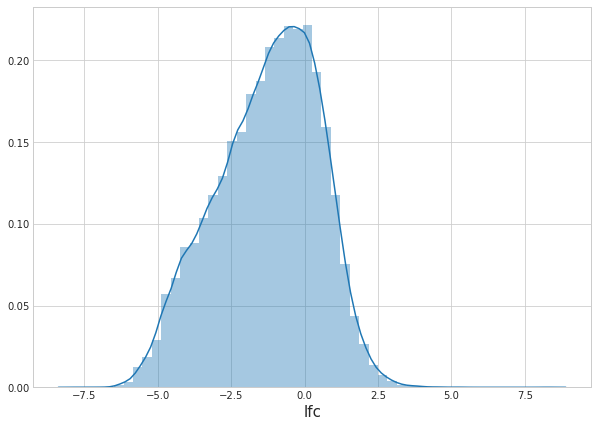

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


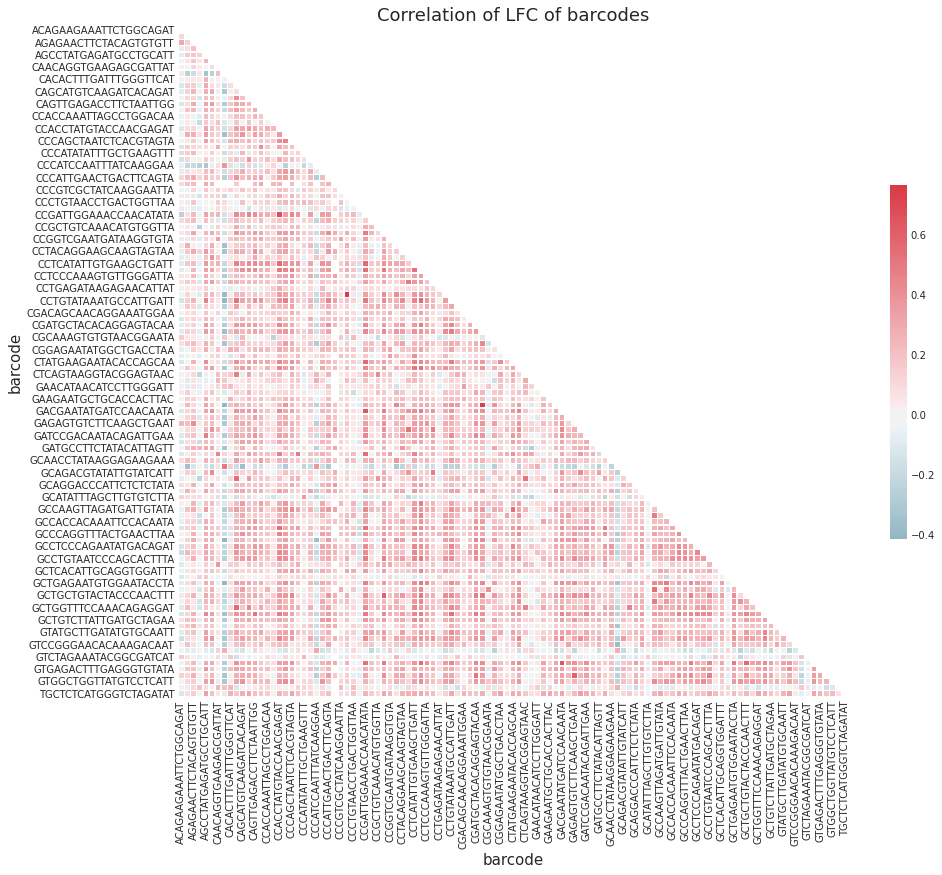

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 20)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(1810, 5)

In [12]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [13]:
model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

In [14]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,7,3
1,ACAGAAGAAATTCTGGCAGAT,dbtrg05mg_central_nervous_system,2.145082,2,EIF6,1,6,3
2,ACAGAAGAAATTCTGGCAGAT,bt20_breast,0.932751,2,EIF6,1,2,3
3,ACAGAAGAAATTCTGGCAGAT,calu1_lung,1.519675,2,EIF6,1,3,3
4,ACAGAAGAAATTCTGGCAGAT,opm2_haematopoietic_and_lymphoid_tissue,0.509560,2,EIF6,1,17,3


Binary matrix of $[shRNA \times gene]$.

In [15]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [16]:
shrna_gene_matrix.shape

(26, 4)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [17]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [18]:
start = timer()
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = pystan.StanModel(file=d2_m1_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a3da92f7ba3e62805394cf29daed746 NOW.


0.90 minutes to compile model


In [19]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

In [20]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [21]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.832,0.070,-1.959,-1.697,0.002,0.001,1823.0,1823.0,1826.0,1306.0,1.0
sigma,1.652,0.049,1.558,1.740,0.001,0.001,2092.0,2082.0,2091.0,1466.0,1.0


/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_k

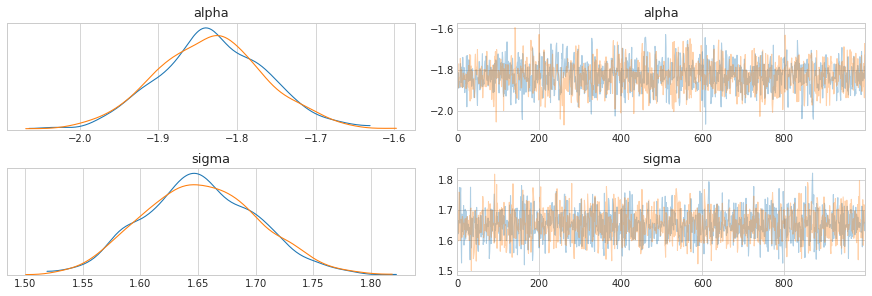

In [22]:
az.plot_trace(az_d2_m1)
plt.show()

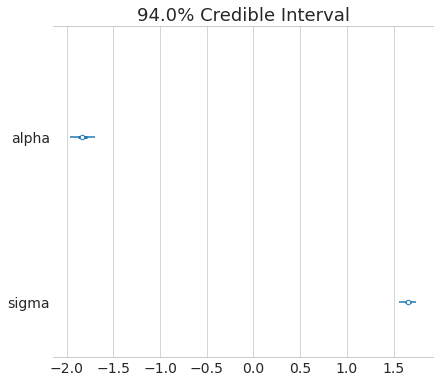

In [23]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

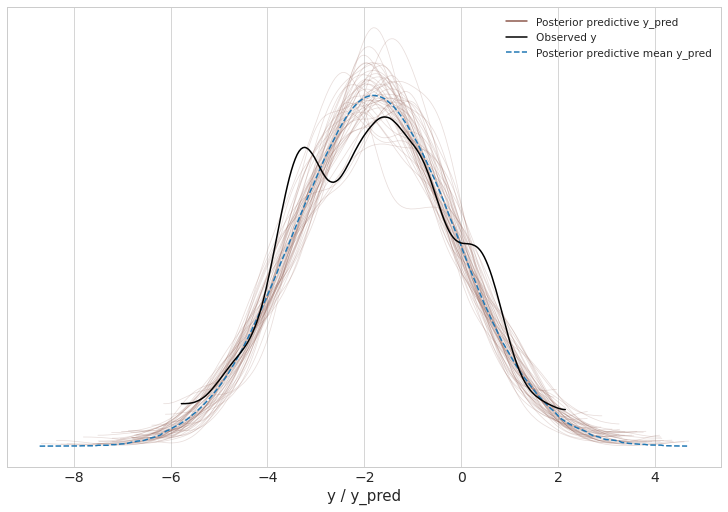

In [24]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [25]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [26]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [27]:
start = timer()
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = pystan.StanModel(file=d2_m2_gen_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_112516ecd402d13dafa0de6e631a9e45 NOW.


0.86 minutes to compile model


In [28]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, iter=10, chains=1, algorithm='Fixed_param')

In [29]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

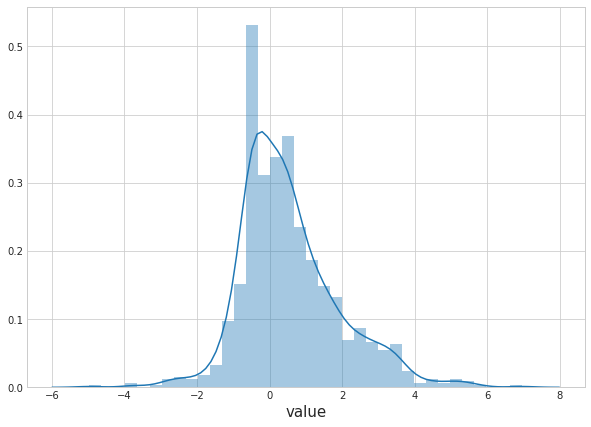

In [30]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

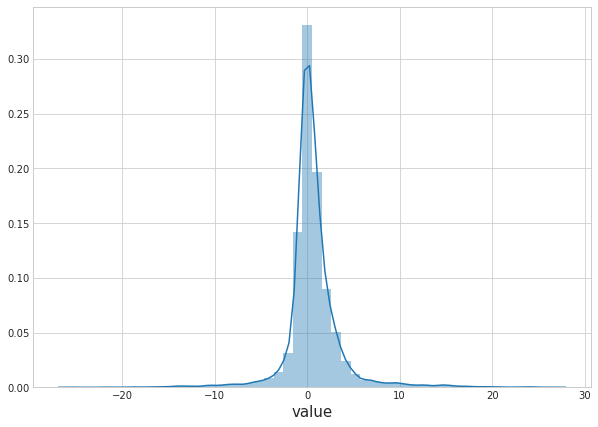

In [31]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

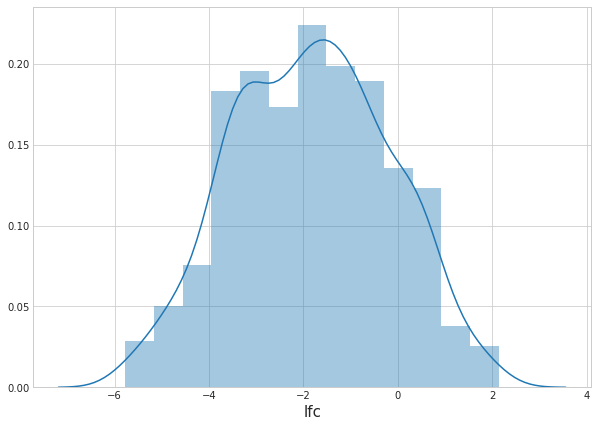

In [32]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [66]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [67]:
d2_m2_data['S']

26

**Compile model.**

The current problem is that the various values for `alpha` of different shRNA are the same because `sigma_alpha` is so small.
Maybe try with just two shRNA, but I need to figure out why the value for `sigma_alpha` is shrinking so fast.

In [68]:
start = timer()
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = pystan.StanModel(file=d2_m2_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a255b296c6c7188c1c436073d69e94c9 NOW.


0.90 minutes to compile model


In [69]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

In [70]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': False}

In [71]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-1.833,0.004,-1.839,-1.826,0.000,0.0,71.0,71.0,72.0,60.0,1.02
sigma_alpha,0.004,0.002,0.001,0.007,0.001,0.0,10.0,10.0,9.0,76.0,1.17
alpha[0],-1.833,0.005,-1.842,-1.823,0.000,0.0,137.0,137.0,132.0,307.0,1.01
alpha[1],-1.833,0.005,-1.842,-1.823,0.000,0.0,148.0,148.0,145.0,363.0,1.01
alpha[2],-1.833,0.005,-1.842,-1.823,0.000,0.0,129.0,129.0,129.0,526.0,1.01


/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


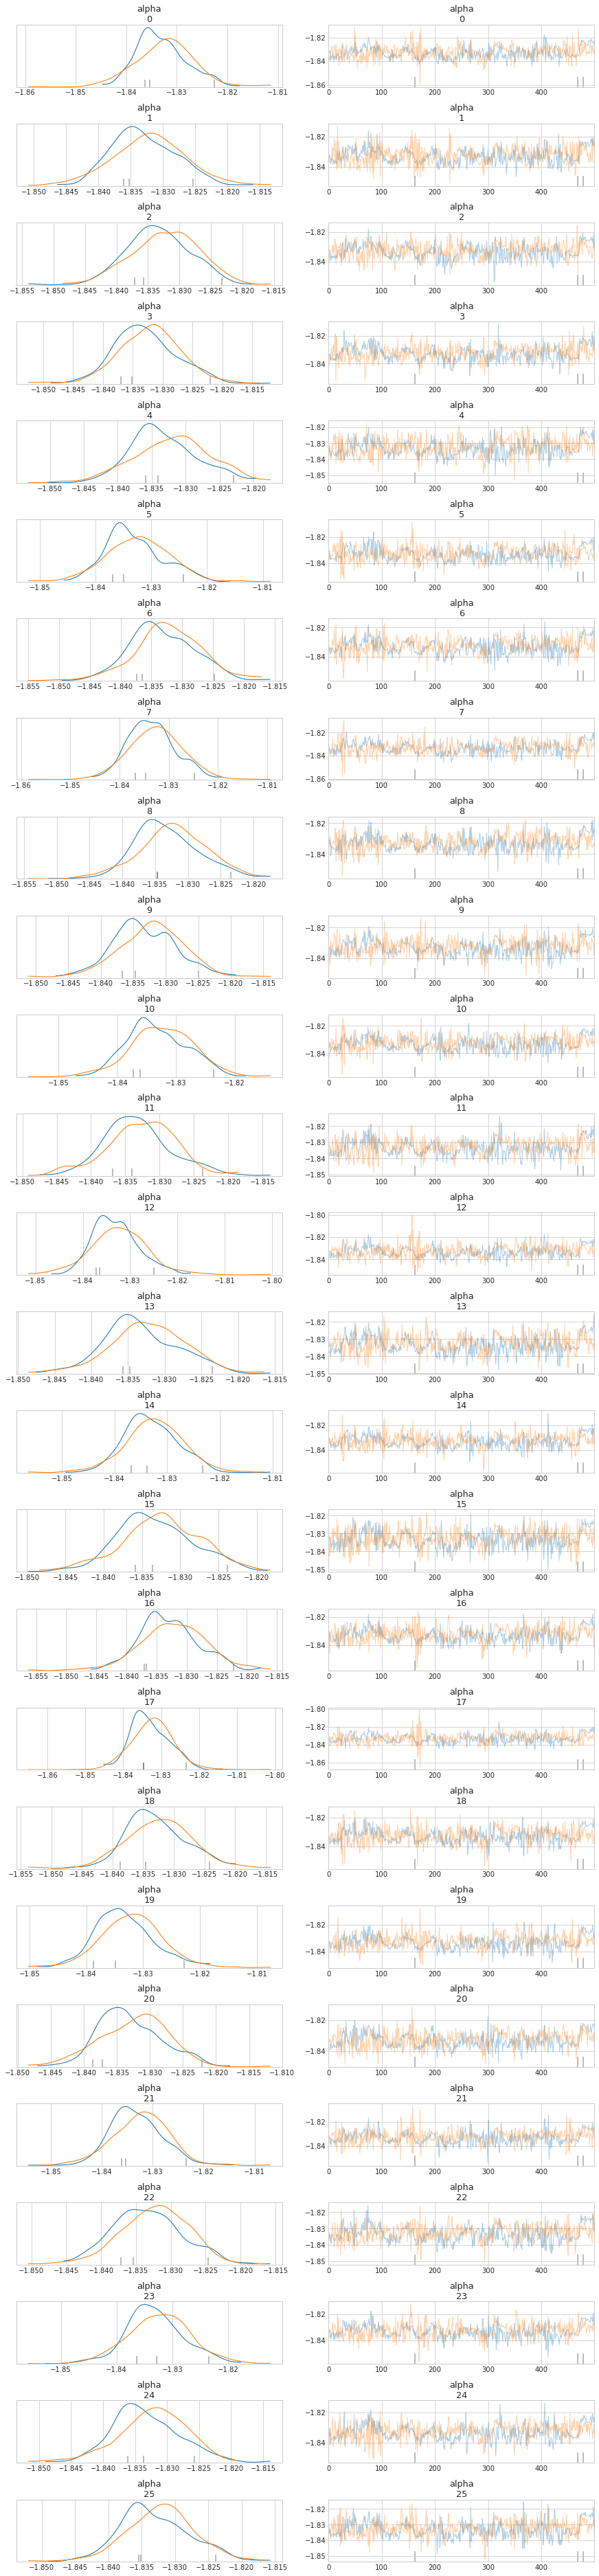

In [72]:
az.plot_trace(az_d2_m2, var_names=['alpha'])
plt.show()

/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


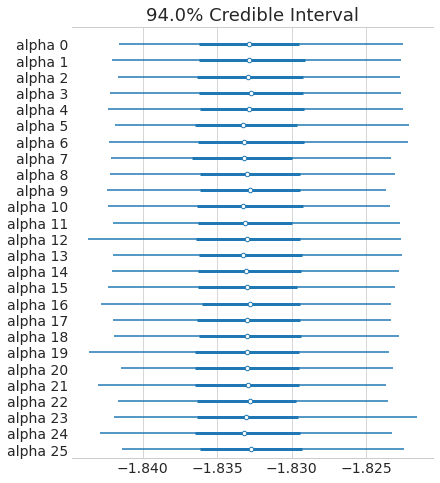

In [73]:
az.plot_forest(az_d2_m2, combined=True, var_names=['alpha'])
plt.show()

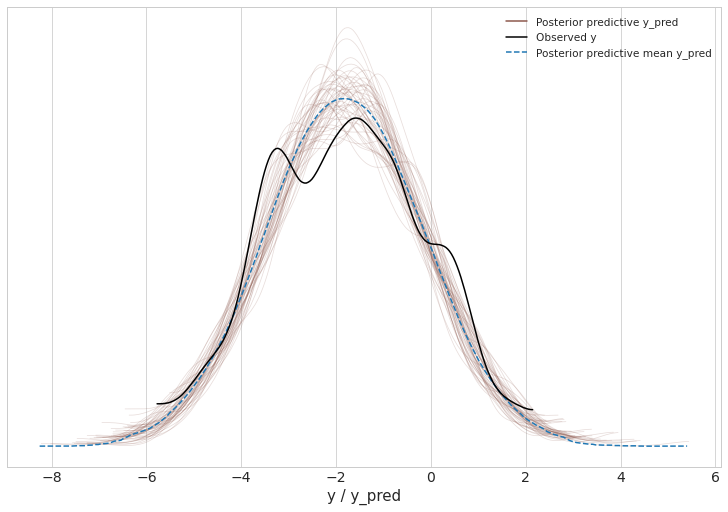

In [74]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [75]:
d2_m2_fit

/home/jc604/.conda/envs/demeter2-stan/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_a255b296c6c7188c1c436073d69e94c9.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_alpha     -1.83  4.2e-4 3.6e-3  -1.84  -1.84  -1.83  -1.83  -1.83     71   1.02
sigma_alpha 3.9e-3  5.0e-4 2.0e-3 1.2e-3 2.4e-3 3.6e-3 5.0e-3 8.5e-3     16   1.15
alpha[1]     -1.83  4.5e-4 5.3e-3  -1.84  -1.84  -1.83  -1.83  -1.82    138   1.01
alpha[2]     -1.83  4.4e-4 5.4e-3  -1.84  -1.84  -1.83  -1.83  -1.82    148   1.01
alpha[3]     -1.83  4.6e-4 5.2e-3  -1.84  -1.84  -1.83  -1.83  -1.82    128   1.01
alpha[4]     -1.83  4.6e-4 5.3e-3  -1.84  -1.84  -1.83  -1.83  -1.82    136   1.01
alpha[5]     -1.83  4.8e-4 5.4e-3  -1.84  -1.84  -1.83  -1.83  -1.82    124   1.02
alpha[6]     -1.83  4.5e-4 5.5e-3  -1.84  -1.84  -1.83  -1.83  -1.82    146   1.01
alpha[7]     -1.83  4.6e-4